In [10]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn

In [469]:
# hyperparameters

DEVICE = 'mps' if torch.mps.is_available() else 'cpu'
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2

In [476]:
# Creating One layer NN

import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, device=DEVICE),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8, device=DEVICE),
            nn.Conv2d(8, 64, kernel_size=5, device=DEVICE),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64, device=DEVICE),
            nn.ReLU(),
        )
        self.lin_layers = nn.Sequential(
            nn.Linear(1024, 512, device=DEVICE),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128, device=DEVICE),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10, device=DEVICE),
        )
    
    def forward(self, input):
        output = self.conv_layers(input)
        output = self.lin_layers(output.view(-1, 1024))
        logits = F.softmax(output, dim=1)
        
        return logits

In [477]:
import torch.optim as optim

model = SimpleNN()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [478]:
# Updated code for train/validation and test sets

from torch.utils.data import DataLoader

In [479]:
train_dataset = MNIST('../', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = MNIST('../', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [480]:
train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [481]:
# Updated training loop with validation loss after every epoch

train_loss = []
val_loss = []

for epoch in range(NUM_EPOCHS):

    model.train()

    running_train_loss = 0
    for batch_idx, (train_data, train_labels) in enumerate(train_loader):
        # put data on device
        train_data = train_data.to(DEVICE)
        train_labels = train_labels.to(DEVICE)

        # run forward pass
        optimizer.zero_grad()
        pred = model(train_data)

        # calculate loss and backwards pass
        loss = F.cross_entropy(pred, train_labels)
        # train_loss.append(loss.item())
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # every 100 batches output loss
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(f"Epoch {epoch} | Batch {batch_idx} | Loss {loss:0.5f}")

    avg_train_loss = running_train_loss / (batch_idx + 1)
    
    train_loss.append(avg_train_loss)
    # after every epoch track the validation loss
    model.eval()

    running_val_loss = 0

    for batch_idx, (val_data, val_labels) in enumerate(val_loader):
        # put data on device
        val_data = val_data.to(DEVICE)
        val_labels = val_labels.to(DEVICE)

        with torch.no_grad():
            pred = model(val_data)
            loss = F.cross_entropy(pred, val_labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / (batch_idx + 1)
    
    print(f"Epoch {epoch} | Training Loss {avg_train_loss:0.5f} | Validation Loss {avg_val_loss:0.5f}")

    val_loss.append(avg_val_loss)


Epoch 0 | Batch 100 | Loss 1.53892
Epoch 0 | Batch 200 | Loss 1.58925
Epoch 0 | Batch 300 | Loss 1.48736
Epoch 0 | Batch 400 | Loss 1.51367
Epoch 0 | Batch 500 | Loss 1.54900
Epoch 0 | Batch 600 | Loss 1.48520
Epoch 0 | Batch 700 | Loss 1.47099
Epoch 0 | Training Loss 1.54213 | Validation Loss 1.48711
Epoch 1 | Batch 100 | Loss 1.47840
Epoch 1 | Batch 200 | Loss 1.48898
Epoch 1 | Batch 300 | Loss 1.47694
Epoch 1 | Batch 400 | Loss 1.47737
Epoch 1 | Batch 500 | Loss 1.48557
Epoch 1 | Batch 600 | Loss 1.47196
Epoch 1 | Batch 700 | Loss 1.47936
Epoch 1 | Training Loss 1.48939 | Validation Loss 1.48331
Epoch 2 | Batch 100 | Loss 1.47494
Epoch 2 | Batch 200 | Loss 1.51436
Epoch 2 | Batch 300 | Loss 1.46601
Epoch 2 | Batch 400 | Loss 1.47128
Epoch 2 | Batch 500 | Loss 1.49176
Epoch 2 | Batch 600 | Loss 1.46372
Epoch 2 | Batch 700 | Loss 1.49648
Epoch 2 | Training Loss 1.48568 | Validation Loss 1.47912
Epoch 3 | Batch 100 | Loss 1.49561
Epoch 3 | Batch 200 | Loss 1.47474
Epoch 3 | Batch 300 |

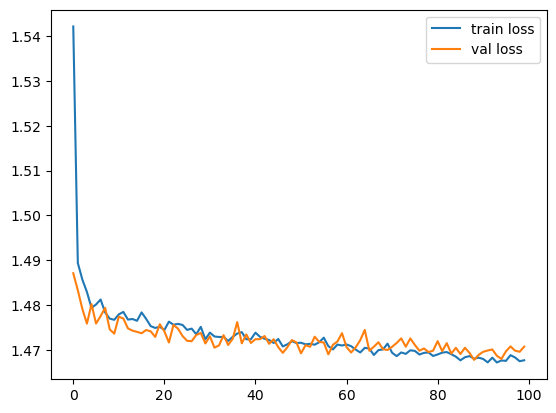

In [482]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()
plt.show()

In [483]:
# test accuracy

model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for batch_idx, (example_data, example_targets) in enumerate(test_loader):
            example_data = example_data.to(DEVICE)
            example_targets = example_targets.to(DEVICE)
            # run forward pass
            output = model(example_data)
            test_loss += F.cross_entropy(output, example_targets)
            output = torch.argmax(output, dim=1)
            correct += sum(output == example_targets)

print(f'test loss: {test_loss/len(test_loader):0.5f}')
print(f'test accuracy: {correct/len(test_loader)/BATCH_SIZE:0.5f}')

test loss: 1.46989
test accuracy: 0.98646


In [485]:
torch.save(model.state_dict, 'MNIST_CNN.pt')

Progress tracker:
- 1 layer NN with 10 epochs of training: 
    - test loss: 1.61052
    - test accuracy: 0.88704
    
- 2 layer NN with 64 size hidden layer, added AdamW optimizer:
    - test loss: 1.53824
    - test accuracy: 0.92038

- 2 layer NN with 128 size hidden layer: (practically no improvement)
    - test loss: 1.53825
    - test accuracy: 0.91929

- 2 layer NN with 64 size hidden layer, added relu after first layer: (relu was necessary ow just liek 1 layer NN)
    - test loss: 1.49081
    - test accuracy: 0.96865

- 3 layer NN with 128 size hidden layer: (architecture is limited)
    - test loss: 1.48965
    - test accuracy: 0.96785

- 1 layer CNN with kernel 3 and padding = 1 joined iwth 1 layer Linear layer: (( appears that regresses to 2 layer NN bc no abstraciton of data))
    - test loss: 1.53574
    - test accuracy: 0.92267

- 2 layer CNN with kernel 3, no padding and increasing channel by 2:
    - test loss: 1.49036
    - test accuracy: 0.96676

- added maxpooling with kernel size 2 in-between conv layers:
    - test loss: 1.49294
    - test accuracy: 0.96537

- relu inbetween convlution layers and deeper channels to 4 and 16: otherwise siimlar to single convlution layer:
    - test loss: 1.48902
    - test accuracy: 0.97014

- larger kernel size - 5:
    - test loss: 1.47957
    - test accuracy: 0.97850

- second linear layer:
    - test loss: 1.47536
    - test accuracy: 0.98278

- dropout for overfitting, only after dense layers: (possibly overfitting after running 10 epochs)
    - test loss: 1.47994
    - test accuracy: 0.97751

- dropout in between convolution layers 20 epoch before overfitting:
    - test loss: 1.47057
    - test accuracy: 0.98597